# **PHOTOGRAPHIC RECIPE SEARCH**

Daniel Lu, Kooresh Akhbari, Defne Dilbaz, Yousif Alfuraiji

APS360 Team 32

**Important Team Notes**

*   This Google Colab file is in a shared folder called APS360-Project. Please make sure to copy this folder to your home directory on Google Drive — that is, the path to this file should be `drive/My Drive/APS360-Project/Project.ipynb` for everybody.



**Preliminary Code**

Code that needs to be run at the beginning of every project.

In [5]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
!pip install split-folders
import split_folders
import torchvision.models
import os
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

**Code to Apply Transforms**

https://pytorch.org/docs/stable/torchvision/transforms.html

The ```apply_transform``` function is meant to apply a series of transforms. Passing in a list of numbers will apply those transforms, in the order that they are passed in. The table of transforms is given below.

```
 num | description            
  0  | no transform
  1  | random rotation
  2  | random brightness adjustment
  3  | grayscale
  4  | horizontal flip
  5  | vertical flip
  6  | random contrast adjustment
  7  | random hue adjustment
  8  | random saturation adjustment
```

For example, passing in ```num = [1,3,4]``` will return the ingredients dataset where each ingredient image has been randomly rotated, then greyscaled, then horizontally flipped.

If baseline is specified as True, the images will be scaled down to 50x50px. 

In [6]:
!unzip 'drive/My Drive/2019-2020 (Third Year)/APS360/Local Project/Data/ingredients.zip' -d '/root/Ingredients'

unzip:  cannot find or open drive/My Drive/2019-2020 (Third Year)/APS360/Local Project/Data/ingredients.zip, drive/My Drive/2019-2020 (Third Year)/APS360/Local Project/Data/ingredients.zip.zip or drive/My Drive/2019-2020 (Third Year)/APS360/Local Project/Data/ingredients.zip.ZIP.


In [1]:
def get_transform(num):
    """
    Helper function forwd apply_transform

    Parameters:
        num (int): number corresponding to transforms (see table above)
    
    Returns:
        Transform: transform (see table above)
    """
    transform = {
        1:transforms.RandomRotation(180),
        2:transforms.ColorJitter(brightness=0.3),
        3:transforms.Grayscale(3),
        4:transforms.RandomHorizontalFlip(p=1.0),
        5:transforms.RandomVerticalFlip(p=1.0),
        6:transforms.ColorJitter(contrast=0.2),
        7:transforms.ColorJitter(hue=0.1),
        8:transforms.ColorJitter(saturation=0.1)
    }
    return transform.get(num)


def apply_transform(nums, baseline=False, transfer=False):
    """
    Applies a list of input transforms in order on a dataset.

    Parameters:
        nums (list): A list of numbers representing transforms (see table above).
        baseline (bool): Whether this loader is being used for the baseline model or not
    
    Returns:
        ImageFolder: Ingredient dataset with the transforms applied in order.
    """

    # Create the array of transforms based on the input numbers
    transform_list = []
    if (baseline):
        transform_list.append(transforms.Resize((50,50)))
    elif (transfer):
        transform_list.append(transforms.Resize((224,224)))
    else:
        transform_list.append(transforms.CenterCrop(200))
    for n in nums:
        if 1 <= n <= 8:
            transform_list.append(get_transform(n))
    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

    # Initialize the transform object from the lsit of transforms
    transform = transforms.Compose(transform_list)

    # Load all ingredient with the given transform
    ingredient_dataset = datasets.ImageFolder(
        root = 'Ingredients',
        transform = transform
    )

    return ingredient_dataset

**Code for Augmenting and Loading Data**

The ```get_data_loader``` function returns the training, validation, and test loaders that will be used to train the neural network. 

In [2]:
def get_transformed_data(transformations, baseline=False, transfer=False):
    """
    Gets a dataset of all the transformations that the user specified

    Parameters:
        transformations (list): List of transformations that will be applied
        baseline (bool): Whether this function is being used for the baseline model or not

    Returns: List of datasets that got transformations applied
    """
    data_set = []
    transformations.append([0])
    
    for transforms in transformations:
        data_set.append(apply_transform(transforms, baseline, transfer))
    return data_set

In [3]:
def shuffle_indices(list_indicies):
    np.random.seed(1250)

    np.random.shuffle(list_indicies)

    list_len = len(list_indicies)
    train_cutoff = int(list_len * 0.6)
    val_cutoff = int(list_len * 0.8)

    train_indx_shuffled = list_indicies[:train_cutoff]
    val_indx_shuffled = list_indicies[train_cutoff:val_cutoff]
    test_indx_shuffled = list_indicies[val_cutoff:]

    return train_indx_shuffled, val_indx_shuffled, test_indx_shuffled

In [10]:
def get_data_loader(trans_list, batch_size, baseline=False, transfer=False):
    """
    Gets the training, validation, and test loaders.

    Parameters: 
        trans_list (list): List of lists that contains the transformations to be applied
                          eg: [[1,2,3], [1,4,2]]  
        batch_size (int): Desired batch size
        baseline (bool): Whether this function is being used for the baseline model or not
    
    Returns:
        DataLoader, DataLoader, DataLoader: training, validation, and test DataLoaders
    """

    classes = ['almond', 'apple', 'asparagus', 'bacon', 'banana', 'beef_ground',
               'beef_steak', 'beet', 'blueberries', 'brussel_sprout', 'bun_hamburger',
               'bun_hotdog', 'butter', 'cabbage', ' carrot', 'cauliflower', 'celery',
               'cheese_block', 'cheese_shredded', 'chicken_breast', 'chicken_leg',
               'chicken_wing', 'corn', 'croissant', 'cucumber', 'egg', 'garlic',
               'ginger', 'grape', 'honey', 'ketchup', 'lemon', 'lobster', 'mango',
               'mayonnaise', 'milk', 'mushroom', 'mustard', 'noodle', 'oil_vegetable', 
               'onion', 'orange', 'peach', 'pear', 'pepper_bell', 'pepper_chile', 
               'pineapple', 'potato', 'rice', 'salmon', 'sausage', 'scallion',
               'shrimp', 'spaghetti', 'spinach', 'thyme', 'tomato', 'vinegar']
    

    list_dataset = get_transformed_data(trans_list, baseline, transfer)
    #Concatenate the datasets into one big dataset
    dataset = ConcatDataset(list_dataset)

    print("Total number of pictures after transformataions: " + str(len(dataset)))

    #Shuffle indicies
    train_indices, val_indices, test_indices = shuffle_indices(list(range(len(dataset))))

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    #Load the data
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                               num_workers=1, sampler=test_sampler)
    

    print('Len train_loader: ', len(train_loader))
    print('Len val_loader: ', len(val_loader))
    print('Len test_loader: ', len(test_loader))

    if (baseline):
        print('All DataLoaders initialized for baseline model')
    elif (transfer):
        print('All DataLoaders initialized for transfer model')
    else:
        print('All DataLoaders initialized for full neural network')

    return train_loader, val_loader, test_loader, classes

**Code to Get DataLoaders for Baseline Model**

The following code initializes the train_loader, val_loader, and test_loader for the baseline model (50x50px images) and the full neural network (200x200px images). Once run, these values can be used directly in training the baseline model.

All labels in the DataLoaders are numerical figure (ex. 0 = almond, 1 = apple, etc.). The ```classes``` variable maps label numbers to ingredient names (ex. ```classes[0]``` will return ```'almond'```).

This code also prints the size of each DataLoader and the total number of pictures.

In [11]:
transformations_apply = [[2,6], [2,6,7,8], [2,6,1], [2,6,7,8,1], [2,6], [2,6,4], [2,6,7,8,5]]
batch = 32
train_loader_baseline, val_loader_baseline, test_loader_baseline, classes = get_data_loader(transformations_apply, batch_size=batch, baseline=True)
train_loader, val_loader, test_loader, classes = get_data_loader(transformations_apply, batch)
train_loader_transfer, val_loader_transfer, test_loader_transfer, classes = get_data_loader(transformations_apply, batch_size=batch, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  1404
Len val_loader:  468
Len test_loader:  468
All DataLoaders initialized for baseline model
Total number of pictures after transformataions: 84231
Len train_loader:  1580
Len val_loader:  527
Len test_loader:  527
All DataLoaders initialized for full neural network
Total number of pictures after transformataions: 93590
Len train_loader:  1755
Len val_loader:  585
Len test_loader:  585
All DataLoaders initialized for transfer model


**Code to Verify Images**

**THIS CODE DOES NOT NEED TO BE RUN.** The following code just visualizes some of the images in train_loader to make sure they are of acceptable quality. None of the following variables will be used anymore for the project.

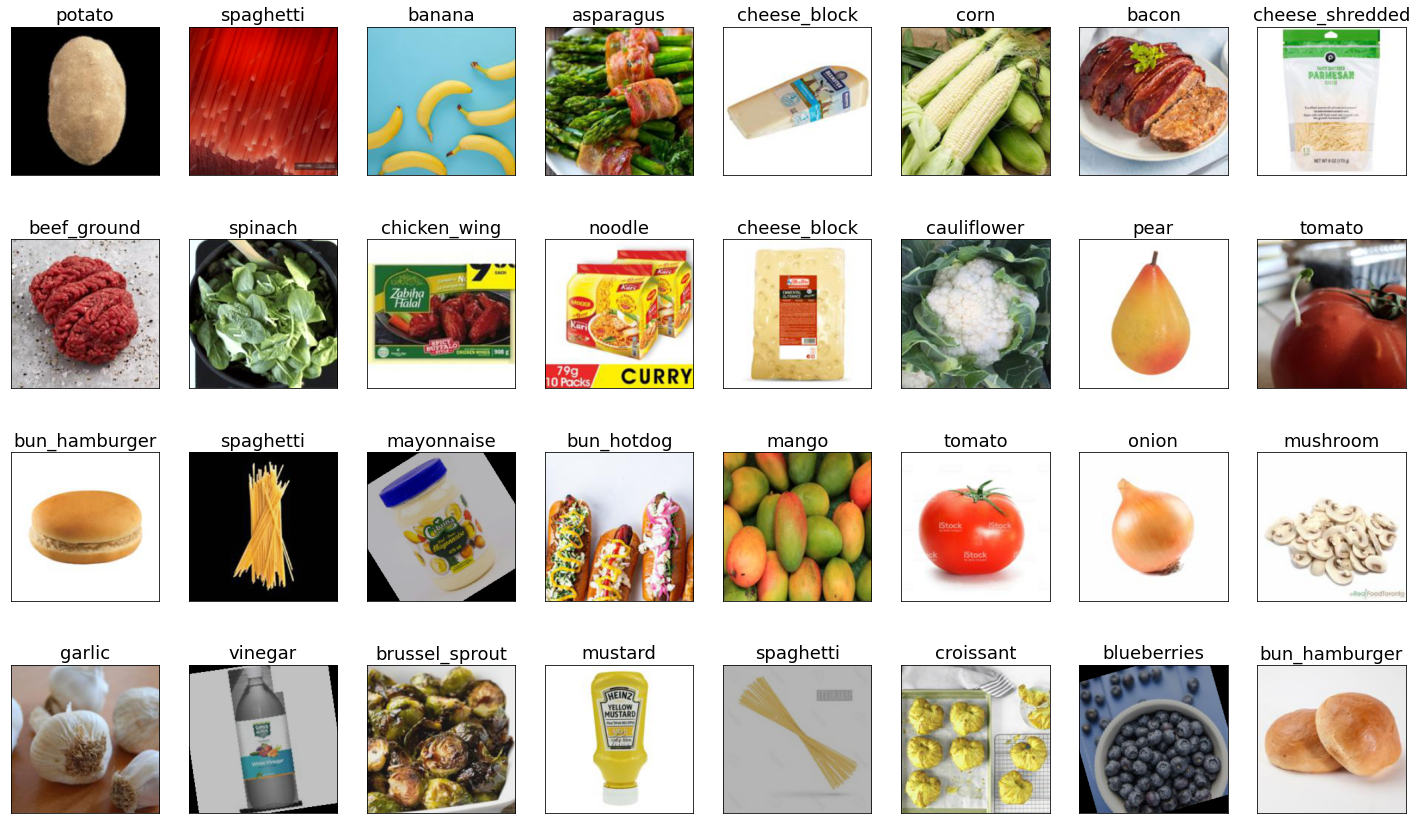

In [12]:
# THIS CODE DOES NOT NEED TO BE RUN

# obtain one batch of training images
dataiter = iter(train_loader_transfer)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
images = images / 2 + 0.5
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25,15))
for idx in np.arange(32):
    ax = fig.add_subplot(4, 32/4, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]], fontsize=18)

**Baseline Model**

NOTES TO YOUSIF AND DEFNE:

* Please make a local copy of the APS360-Project for training. MAKE SURE IT IS LOCAL!
* Please read all of the annotations above! You don't have to touch any of the above code, just run it (if you encounter issues, message Kooresh or Daniel)
* By running all of the above code, train_loader, val_loader, and test_loader have been initialized. Use these DataLoaders to train your code.
* Please remember to keep track of all architectures you train in https://docs.google.com/spreadsheets/d/1oQcA4yKam8iQfyHtsZV9JOXIjvXUS3MCSUgjVc9QBIU/edit?usp=sharing

**Code to Train a Given Model**

The following trains a model, saves the new parameters, and plots the resulting performance.

Note: `get_data_loader` function is called in train to keep the batch size consistent everytime.

Another note: we might want to randomize the `transformations_apply` vector inside of the train function later.

In [13]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    dir_path = name + "-bs" + str(batch_size) + "-lr" + str(learning_rate)
    if not os.path.isdir(dir_path):
        os.mkdir(dir_path)
    path = dir_path + "/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path



def get_accuracy(model, data_loader, transfer=False):
    """ Calculates accuracy for a given model and a given data_loader
    Args:
      model: ANN model
      data_loader: one of val_loader, train_loader, test_loader, etc
    Returns:
      correct/total = correct labelled images/ total number of images
    """
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = None
        if (transfer):
            output = model(alexnet.features(imgs))
        else:
            output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total



def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation acc/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = train_acc.size # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()



def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data

        if torch.cuda.is_available():
          inputs = inputs.cuda()
          labels = labels.cuda()

        # labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss



def transfer_loader(train_loader, val_loader, test_loader):
    
    training_features = None
    training_labels = None
    val_features = None
    val_labels = None
    test_features = None
    test_labels = None

    # Get features from first batch
    for i, data in enumerate(train_loader, 0):
        training_inputs, training_labels = data
        training_features = alexnet.features(training_inputs)
        break

    for i, data in enumerate(val_loader, 0):
        val_inputs, val_labels = data
        val_features = alexnet.features(val_inputs)
        break

    for i, data in enumerate(test_loader, 0):
        test_inputs, test_labels = data
        test_features = alexnet.features(test_inputs)
        break

    training_features = torch.from_numpy(training_features.detach().numpy())
    training_dataset = torch.utils.data.TensorDataset(training_features, training_labels)
    train_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 256, num_workers = 1)
    val_features = torch.from_numpy(val_features.detach().numpy())
    val_dataset = torch.utils.data.TensorDataset(val_features, val_labels)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 256, num_workers = 1)
    test_features = torch.from_numpy(test_features.detach().numpy())
    test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256, num_workers = 1)
    
    return train_loader, val_loader, test_loader



def train(model, batch_size=32, num_epochs=1, learning_rate=1e-2, baseline=False, transfer=False):

    assert (baseline != transfer)

    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Load the Data
    transformations_apply = [[2,6], [2,6,7,8], [2,6,1], [2,6,7,8,1], [2,6], [2,6,4], [2,6,7,8,5]]
    train_loader, val_loader, test_loader, classes = get_data_loader(transformations_apply, batch_size, baseline, transfer)

    # Set the loss and optimizers
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_acc, val_acc, train_loss, val_loss= [], [], [], []
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    count = 0
    total_time = 0
    for epoch in range(num_epochs):

        # get start time to see how fast your model is for each epoch
        start_time = time.time()
        cur_time = time.time()
        total_train_loss = 0.0
        train_iterations = 0
        for imgs, labels in iter(train_loader):
            
            count += 1
            if (count % 10 == 0):
              print("{0} elapsed time: {1}".format(count, time.time()-cur_time))
            cur_time = time.time()
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            outputs = model(alexnet.features(imgs))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_train_loss += loss.item()
            train_iterations += 1
        
        total_val_loss = 0.0
        val_iterations = 0

        count = 0
        for imgs, labels in iter(val_loader):
          
            count += 1
            # print(count)
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              
            outputs = model(alexnet.features(imgs))
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            val_iterations += 1
        
        train_acc[epoch] = get_accuracy(model, train_loader, transfer)
        train_loss[epoch] = float(total_train_loss) / train_iterations
        val_acc[epoch] = get_accuracy(model, val_loader, transfer)
        val_loss[epoch] = float(total_val_loss) / val_iterations

        total_time += time.time()-start_time

        print("epoch: ", epoch)
        print("Elapsed time: {0}".format(time.time()-start_time))
        print("train acc: {0} train loss: {1} val acc: {2} val loss: {3}".format(train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Average time per epoch: {0}".format(total_time/num_epochs))

    model_path = get_model_name(model.name, batch_size, learning_rate, num_epochs - 1)
    plot_training_curve(model_path)    

**Code for Baseline Model**

Let's define a very basic model and test it

Let's train a transfer model!

In [14]:
class Transfer1(nn.Module):
    def __init__(self):
        super(Transfer1, self).__init__()
        self.name = "Transfer1_Kooresh"
        self.conv1 = nn.Conv2d(256, 30, 2)
        self.fc1 = nn.Linear(30 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 30 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
class Transfer2(nn.Module):
    def __init__(self):
        super(Transfer2, self).__init__()
        self.name = "Transfer2_Kooresh"
        self.conv1 = nn.Conv2d(256, 100, 2)
        self.fc1 = nn.Linear(100 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 100 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
class Transfer3(nn.Module):
    def __init__(self):
        super(Transfer3, self).__init__()
        self.name = "Kooresh_Transfer3_contd95"
        self.conv1 = nn.Conv2d(256, 70, 2)
        self.fc1 = nn.Linear(70 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 70 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
class Transfer4(nn.Module):
    def __init__(self):
        super(Transfer4, self).__init__()
        self.name = "Transfer4Kooresh"
        self.conv1 = nn.Conv2d(256, 70, 2)
        self.fc1 = nn.Linear(70 * 5 * 5, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, len(classes))
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 70 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
%%capture output11
#Kooresh  #BEST SO FAR
kooresh_transfer3 = Transfer3()
alexnet = torchvision.models.alexnet(pretrained=True)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3.cuda()
    alexnet.cuda()
train(kooresh_transfer3, batch_size=256, num_epochs=30, learning_rate=8e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.2760398387908936
20 elapsed time: 1.1968634128570557
30 elapsed time: 1.2452752590179443
40 elapsed time: 1.2053649425506592
50 elapsed time: 1.2713088989257812
60 elapsed time: 1.373098611831665
70 elapsed time: 1.2026622295379639
80 elapsed time: 1.240952491760254
90 elapsed time: 1.2140722274780273
100 elapsed time: 1.2728073596954346
110 elapsed time: 1.2338156700134277
120 elapsed time: 1.2153267860412598
130 elapsed time: 1.299196720123291
140 elapsed time: 1.203425645828247
150 elapsed time: 1.2433035373687744
160 elapsed time: 1.2874836921691895
170 elapsed time: 1.1646144390106201
epoch:  0
Elapsed time: 594.4215395450592
train acc: 0.4377935578656813 train loss: 3.0440560349009256 val acc: 0.4251369039668759 val loss: 2.369474411010742
60 elapsed time: 1.3343796730041504
70 elapsed time: 1.1533

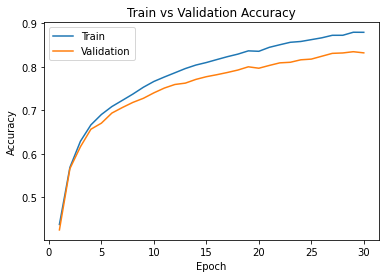

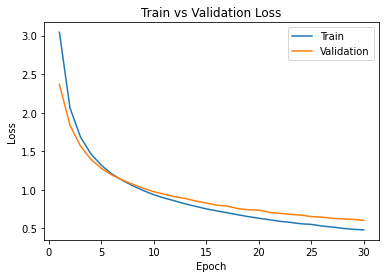

In [90]:
output11.show()

In [121]:
%%capture output21
#Run prev for 10 more epoch BEST SO FAR!!!! 
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3-bs256-lr8e-05/model_Kooresh_Transfer3_bs256_lr8e-05_epoch29'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=10, learning_rate=8e-5, transfer=True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
10 elapsed time: 1.1910333633422852
20 elapsed time: 1.214085340499878
30 elapsed time: 1.2142033576965332
40 elapsed time: 1.2740983963012695
50 elapsed time: 1.272655725479126
60 elapsed time: 1.2560818195343018
70 elapsed time: 1.2393450736999512
80 elapsed time: 1.285127878189087
90 elapsed time: 1.2198245525360107
100 elapsed time: 1.3054757118225098
110 elapsed time: 1.1604816913604736
120 elapsed time: 1.2644612789154053
130 elapsed time: 1.3105673789978027
140 elapsed time: 1.2245285511016846
150 elapsed time: 1.3054568767547607
160 elapsed time: 1.2045869827270508
170 elapsed time: 1.2059521675109863
epoch:  0
Elapsed time: 600.4883303642273
train acc: 0.8844021993188345 train loss: 0.4661875343458219 val acc: 0.8363162815546948 val loss: 0.5974404448169773
60 elapsed time: 1.5437965393066406
70 elapsed time: 1.17

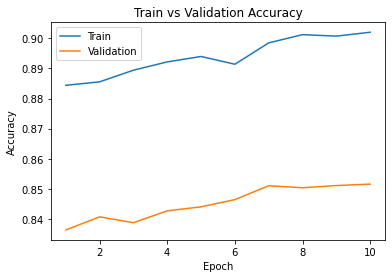

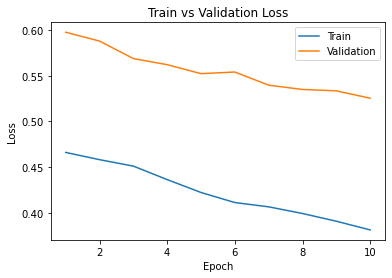

In [122]:
output21.show()

In [ ]:
%%capture output22
#Run prev for 10 more epoch BEST SO FAR!!!! (50)
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3_contd-bs256-lr8e-05/model_Kooresh_Transfer3_contd_bs256_lr8e-05_epoch9'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=10, learning_rate=8e-5, transfer=True)

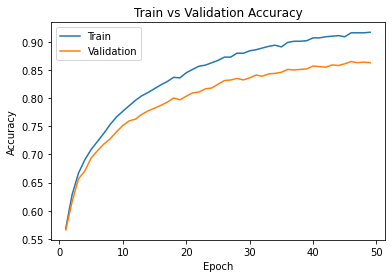

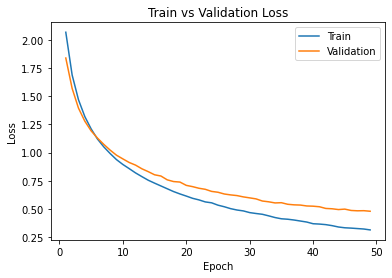

In [146]:
import matplotlib.pyplot as plt
import pandas as pd
train_ac = pd.read_excel("Kooresh_Transfer3_contd50-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch49_trainacc.xlsx")
train_acc = np.array(train_ac)

val_ac = pd.read_excel("Kooresh_Transfer3_contd50-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch49_valacc.xlsx")
val_acc = np.array(val_ac)



train_los = pd.read_excel("Kooresh_Transfer3_contd50-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch49_trainloss.xlsx")
train_loss = np.array(train_los)

val_los = pd.read_excel("Kooresh_Transfer3_contd50-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch49_valloss.xlsx")
val_loss = np.array(val_los)



plt.title("Train vs Validation Accuracy")
n = train_acc.size # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()


plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()



In [ ]:
%%capture output23
#Run prev for 5 more epoch BEST SO FAR!!!! (5)
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3_contd50-bs256-lr8e-05/model_Kooresh_Transfer3_contd50_bs256_lr8e-05_epoch9'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=5, learning_rate=8e-5, transfer=True)

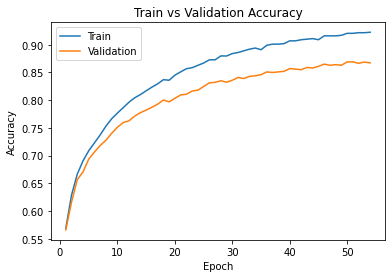

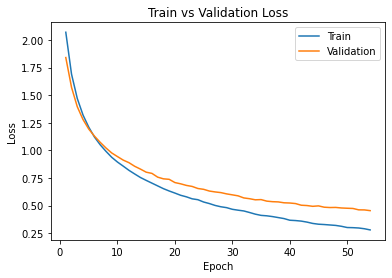

In [144]:
import matplotlib.pyplot as plt
import pandas as pd
train_ac = pd.read_excel("Kooresh_Transfer3_contd55-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch50_trainacc.xlsx")
train_acc = np.array(train_ac)

val_ac = pd.read_excel("Kooresh_Transfer3_contd55-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch50_valacc.xlsx")
val_acc = np.array(val_ac)



train_los = pd.read_excel("Kooresh_Transfer3_contd55-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch50_trainloss.xlsx")
train_loss = np.array(train_los)

val_los = pd.read_excel("Kooresh_Transfer3_contd55-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch50_valloss.xlsx")
val_loss = np.array(val_los)



plt.title("Train vs Validation Accuracy")
n = train_acc.size # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()


plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()



In [ ]:
%%capture output23
#Run prev for 5 more epoch BEST SO FAR!!!! (60)
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3_contd55-bs256-lr8e-05/model_Kooresh_Transfer3_contd55_bs256_lr8e-05_epoch4'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=5, learning_rate=8e-5, transfer=True)

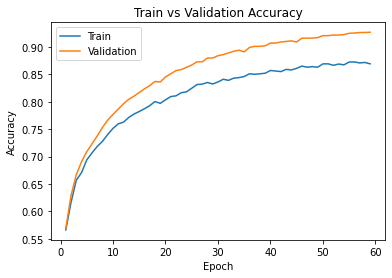

In [149]:
import matplotlib.pyplot as plt
import pandas as pd
train_ac = pd.read_excel("Kooresh_Transfer3_contd65-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch65_valacc.xlsx")
train_acc = np.array(train_ac)

val_ac = pd.read_excel("Kooresh_Transfer3_contd65-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch65_trainacc.xlsx")
val_acc = np.array(val_ac)




plt.title("Train vs Validation Accuracy")
n = train_acc.size # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()




In [151]:
%%capture output24
#Run prev for 15 more epoch BEST SO FAR!!!! (75)
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3_contd65-bs256-lr8e-05/model_Kooresh_Transfer3_contd65_bs256_lr8e-05_epoch4'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=15, learning_rate=8e-5, transfer=True)

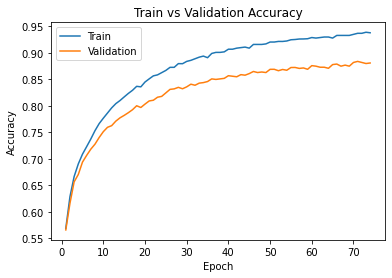

In [152]:
import matplotlib.pyplot as plt
import pandas as pd
train_ac = pd.read_excel("Kooresh_Transfer3_contd75-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch49_trainacc.xlsx")
train_acc = np.array(train_ac)

val_ac = pd.read_excel("Kooresh_Transfer3_contd75-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch49_valacc.xlsx")
val_acc = np.array(val_ac)




plt.title("Train vs Validation Accuracy")
n = train_acc.size # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()




In [154]:
%%capture output25
#Run prev for 10 more epoch BEST SO FAR!!!! (85)
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3_contd75-bs256-lr8e-05/model_Kooresh_Transfer3_contd75_bs256_lr8e-05_epoch14'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=10, learning_rate=8e-5, transfer=True)

In [ ]:
output25.show()

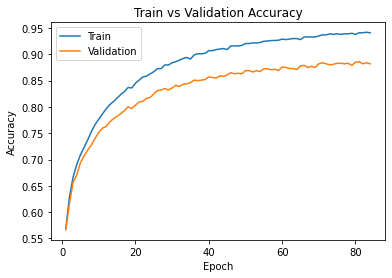

In [155]:
import matplotlib.pyplot as plt
import pandas as pd
train_ac = pd.read_excel("Kooresh_Transfer3_contd85-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch85_trainacc.xlsx")
train_acc = np.array(train_ac)

val_ac = pd.read_excel("Kooresh_Transfer3_contd85-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch85_valacc.xlsx")
val_acc = np.array(val_ac)


plt.title("Train vs Validation Accuracy")
n = train_acc.size # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()



In [158]:
%%capture output26
#Run prev for 10 more epoch BEST SO FAR!!!! (95)
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3_contd85-bs256-lr8e-05/model_Kooresh_Transfer3_contd85_bs256_lr8e-05_epoch9'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()
train(kooresh_transfer3_contd, batch_size=256, num_epochs=10, learning_rate=8e-5, transfer=True)

In [ ]:
#The graphs shown below are our best results from our primary model! :) 

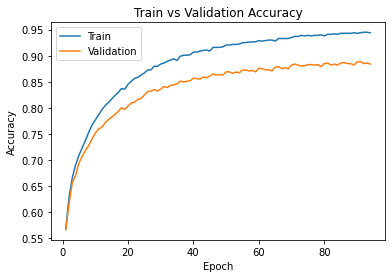

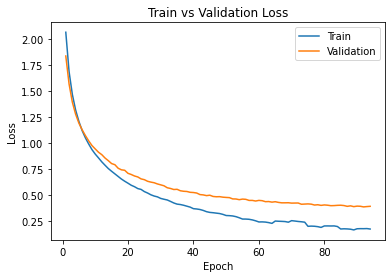

In [161]:
import matplotlib.pyplot as plt
import pandas as pd
train_ac = pd.read_excel("Kooresh_Transfer3_contd95-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch95_trainacc.xlsx")
train_acc = np.array(train_ac)

val_ac = pd.read_excel("Kooresh_Transfer3_contd95-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch95_valacc.xlsx")
val_acc = np.array(val_ac)



train_los = pd.read_excel("Kooresh_Transfer3_contd95-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch95_trainloss.xlsx")
train_loss = np.array(train_los)

val_los = pd.read_excel("Kooresh_Transfer3_contd95-bs256-lr8e-05/transfer3_kooresh_bs256_lr8e-05_epoch95_valloss.xlsx")
val_loss = np.array(val_los)



plt.title("Train vs Validation Accuracy")
n = train_acc.size # number of epochs
plt.plot(range(1,n+1), train_acc, label="Train")
plt.plot(range(1,n+1), val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()


plt.title("Train vs Validation Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.plot(range(1,n+1), val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()



In [163]:
#Test accuracy:
transformations_apply = [[2,6], [2,6,7,8], [2,6,1], [2,6,7,8,1], [2,6], [2,6,4], [2,6,7,8,5]]
train_loader, val_loader, test_loader, classes = get_data_loader(transformations_apply, 256, False, True)

Total number of pictures after transformataions: 74872
Len train_loader:  176
Len val_loader:  59
Len test_loader:  59
All DataLoaders initialized for transfer model
Hi


In [165]:
kooresh_transfer3_contd = Transfer3()
kooresh_transfer3_path = 'Kooresh_Transfer3_contd95-bs256-lr8e-05/model_Kooresh_Transfer3_contd95_bs256_lr8e-05_epoch9'
kooresh_transfer3_state = torch.load(kooresh_transfer3_path)
kooresh_transfer3_contd.load_state_dict(kooresh_transfer3_state)
use_cuda = True
if use_cuda and torch.cuda.is_available():
    kooresh_transfer3_contd.cuda()
    alexnet.cuda()



get_accuracy(kooresh_transfer3_contd, test_loader, True)

0.879465776293823

In [47]:
# PASSING IMAGES TO BE CLASSIFIED
def classify_image(img_path):
    """
    Classifies an image given an image path.

    Parameters: 
        img_path: A string representing the image file path
    
    Returns:
        A string representing the label 
    """
    transform = transforms.Compose([transforms.Resize((224,224)), 
                      transforms.ToTensor(), 
                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    test_img = transform(Image.open(img_path))
    test_img.unsqueeze_(0)
    input = Variable(test_img)
    model = Transfer3()
    model_path = 'Kooresh_Transfer3_contd95-bs256-lr8e-05/model_Kooresh_Transfer3_contd95_bs256_lr8e-05_epoch9'
    model_state = torch.load(model_path)
    model.load_state_dict(model_state)
    alexnet = torchvision.models.alexnet(pretrained=True)
    label = model(alexnet.features(input))
    classes = ['almond', 'apple', 'asparagus', 'bacon', 'banana', 'beef_ground',
               'beef_steak', 'beet', 'blueberries', 'brussel_sprout', 'bun_hamburger',
               'bun_hotdog', 'butter', 'cabbage', ' carrot', 'cauliflower', 'celery',
               'cheese_block', 'cheese_shredded', 'chicken_breast', 'chicken_leg',
               'chicken_wing', 'corn', 'croissant', 'cucumber', 'egg', 'garlic',
               'ginger', 'grape', 'honey', 'ketchup', 'lemon', 'lobster', 'mango',
               'mayonnaise', 'milk', 'mushroom', 'mustard', 'noodle', 'oil_vegetable', 
               'onion', 'orange', 'peach', 'pear', 'pepper_bell', 'pepper_chile', 
               'pineapple', 'potato', 'rice', 'salmon', 'sausage', 'scallion',
               'shrimp', 'spaghetti', 'spinach', 'thyme', 'tomato', 'vinegar']
    return classes[label.data.numpy().argmax()]

classify_image('demo_imgs/01.JPG')

RuntimeError: Calculated padded input size per channel: (228 x 7). Kernel size: (11 x 11). Kernel size can't be greater than actual input size

In [19]:
def classify_folder(folder_path):
    """
    Classifies a list of images in a folder given the folder path

    Parameters: 
        folder_path: A string representing the folder file path
    
    Returns:
        A list of strings representing the labels of each image 
    """
    labels = []
    for img in os.listdir(folder_path):
        if (img.endswith(".jpg") 
            or img.endswith(".png")
            or img.endswith(".JPG")
            or img.endswith(".PNG")):
            labels.append(classify_image(folder_path + "/" + img))
    return labels

print(classify_folder('demo_imgs'))

ingredients_found = classify_folder('demo_imgs')

['rice', 'egg', 'lobster', 'oil_vegetable', 'chicken_leg', 'cucumber', 'onion', 'pepper_bell', 'mushroom', 'bun_hamburger', 'beet', 'chicken_breast', 'onion', 'orange', 'sausage', 'cheese_block', 'beef_steak', 'chicken_breast', ' carrot', 'pepper_bell', 'cucumber', 'mango', 'milk', 'spinach', 'milk', 'scallion', 'onion', 'cabbage', 'bacon', 'mushroom', 'banana', 'spaghetti', 'salmon', 'ketchup', 'mayonnaise', 'pear', 'tomato', 'pepper_bell', 'chicken_breast', 'thyme', 'cheese_block', 'asparagus', 'spaghetti', 'brussel_sprout', 'mayonnaise', 'brussel_sprout', 'celery', 'beef_ground', 'cheese_block', 'cucumber']


In [40]:
def find_recipes(ingredient_list):
    """
    returns recipes found in the API that include the ingredients in ingredientsList

    Parameters: 
        ingredient_list: A list of ingredient strings
    
    Returns:
        A JSON of the API 
    """
    import requests
    
    for i in range(3):
        cutoff = 3 - i

        if len(ingredient_list) > cutoff:
            ingredient_list = ingredient_list[:cutoff]

        ingredient_string = ''
        for ingredient in ingredient_list:
            ingredient_string += ingredient + ', '

        ingredient_string = ingredient_string[:-2]
        print('ingredientString is', ingredient_string)

        # Set up the parameters we want to pass to the API.
        # q: any ingredient in string form
        # app_id is the application ID of recipe search 
        # app_key is the application authentication key
        parameters = {"q": ingredient_string, "app_id": '85b9158f', "app_key": 'b6e60f224ffd3c0a1d048088ada1dc22'}
        # Make a get request with the parameters
        response = requests.get("https://api.edamam.com/search", params=parameters)

        # If status code is 200, the request is successful
        print('Status Code:', response.status_code)

        # Get the response data as a python object.
        data = response.json()

        if len(data['hits']) is 0:
            continue

        for hit in data['hits']:
            try:
                print('Recipe:', hit['recipe']['label'])
                print('Recipe Instructions Link:', hit['recipe']['url'])
                print(' ')
            except:
                pass

        break
            
        return data
    
find_recipes(ingredients_found)


ingredientString is rice, egg, lobster
Status Code: 200
Recipe: Lobster And Arugula Salad With Vanilla Bean Vinaigrette Recipe
Recipe Instructions Link: http://www.foodrepublic.com/2014/02/27/lobster-and-arugula-salad-vanilla-bean-vinaigrette
 
Recipe: Lobster Cantonese
Recipe Instructions Link: https://www.epicurious.com/recipes/food/views/lobster-cantonese-236029
 
Recipe: Lobster Potstickers
Recipe Instructions Link: http://www.thedailymeal.com/recipes/lobster-potstickers-0-recipe
 
Recipe: Lobster And Arugula Salad With Vanilla Bean Vinaigrette recipes
Recipe Instructions Link: http://www.foodrepublic.com/recipes/lobster-and-arugula-salad-with-vanilla-bean-vinaigrette-recipe/
 
Recipe: 'Dragon prawn' noodles
Recipe Instructions Link: http://www.bbc.co.uk/food/recipes/dragonprawnnoodles_89298
 
Recipe: Lobster Cantonese recipes
Recipe Instructions Link: http://www.epicurious.com/recipes/food/views/Lobster-Cantonese-236029
 
Recipe: crispy peach cobbler
Recipe Instructions Link: http

0
1
2
